In [7]:
import os
import time
import random
from itertools import count, combinations

import chess
import pandas as pd

from IPython.display import clear_output

In [8]:
bot_dir = 'bots'
bot_files = [bot_file for bot_file in os.listdir(bot_dir) if bot_file.endswith('.py')]
bot_files = sorted(bot_files)

bot_files

['Odysseus__m_lindenburger_1.py',
 'bot_number_piece.py',
 'bot_piece_value.py',
 'bot_random.py']

In [9]:
# import bots from the files

bot_classes = []

for bot_file in bot_files:
    bot_name = bot_file[:-3]
    bot_module = __import__('bots.' + bot_name, fromlist=[bot_name])
    bot_class = getattr(bot_module, "ChessBot")
    bot_class.name = bot_name
    
    bot_classes.append(bot_class)

print(bot_classes)

[<class 'bots.Odysseus__m_lindenburger_1.ChessBot'>, <class 'bots.bot_number_piece.ChessBot'>, <class 'bots.bot_piece_value.ChessBot'>, <class 'bots.bot_random.ChessBot'>]


In [10]:
class Judge():
    def __init__(self, player_1, player_2, time_limit=300): # 5 minutes per player
        self.player_1 = player_1            # white
        self.player_2 = player_2            # black
        self.time_limit = time_limit

    def run_game(self, initial_board_fen: str = None, slow_down: bool = False, verbose: bool = False):
        if initial_board_fen is None:
            initial_board_fen = chess.Board().fen()
        board = chess.Board(initial_board_fen)

        player_times = [0, 0]
        notes = []
        winner = None

        for i in count(0, 1):
            if board.is_checkmate():
                winner = "black" if i%2 == 0 else "white"
                notes.append(f"Checkmate! Winner is {winner}")
                break
            elif board.is_stalemate():
                notes.append("Stalemate! It's a draw.")
                break
            elif board.is_insufficient_material():
                notes.append("Insufficient material! It's a draw.")
                break
            elif board.is_seventyfive_moves():
                notes.append("Seventy-five moves without a capture or pawn move! It's a draw.")
                break
            elif board.is_fivefold_repetition():
                notes.append("Fivefold repetition! It's a draw.")
                break
            elif board.is_game_over():
                notes.append("Game over! It's a draw.")
                break

            board_fen = board.fen()

            start = time.time()
            if i % 2 == 0:
                move = self.player_1(board_fen)
            else:
                move = self.player_2(board_fen)
            end = time.time()

            player_times[i%2] += end - start

            if player_times[i%2] > self.time_limit:
                winner = "black" if i%2 == 0 else "white"
                notes.append(f"\nTime limit exceeded! Winner is {winner}")
                break

            if not board.is_legal(move):
                winner = "black" if i%2 == 0 else "white"
                hallucinator = "white" if i%2 == 0 else "black"
                notes.append(f"Illegal board move. The {hallucinator} is hallucinating.")
                break

            board.push(move)

            if verbose: 
                clear_output(wait=True)
                display(board)

            # slow down the bots so that we can see them
            if slow_down: 
                time.sleep(.001)

        results = {}
        results['winner'] = winner
        results['times'] = player_times
        results["notes"] = notes

        return results

In [11]:
with open('opennings.txt', 'r') as file:
    opennings = file.read().split('\n')

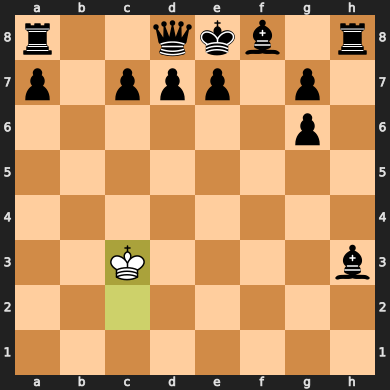

,white_bot,black_bot,winner,white_time,black_time,notes
0,Odysseus__m_lindenburger_1,bot_number_piece,None,0.017602,6.218480,Fivefold repetition! It's a draw.
1,Odysseus__m_lindenburger_1,bot_number_piece,None,0.010143,3.568194,Fivefold repetition! It's a draw.
2,Odysseus__m_lindenburger_1,bot_number_piece,None,0.010623,3.730111,Fivefold repetition! It's a draw.
3,bot_number_piece,Odysseus__m_lindenburger_1,None,9.130449,0.027215,Fivefold repetition! It's a draw.
4,bot_number_piece,Odysseus__m_lindenburger_1,None,9.115433,0.027137,Fivefold repetition! It's a draw.
5,bot_number_piece,Odysseus__m_lindenburger_1,None,9.135148,0.027168,Fivefold repetition! It's a draw.
6,Odysseus__m_lindenburger_1,bot_piece_value,None,0.010177,3.611683,Fivefold repetition! It's a draw.
7,Odysseus__m_lindenburger_1,bot_piece_value,None,0.017554,6.326008,Fivefold repetition! It's a draw.
8,Odysseus__m_lindenburger_1,bot_piece_value,None,0.010240,3.647902,Fivefold repetition! It's a draw.
9,bot_piece_value,Odysseus__m_lindenburger_1,None,6.868680,0.018673,Fivefold repetition! It's a draw.


In [12]:
# play all bots against each other

N_GAMES = 3 # per pair color (so N_GAMES * 2 games per pair of bots)

game_results = pd.DataFrame(columns=['white_bot', 'black_bot', 'winner', 'white_time', 'black_time', 'notes'])

for bot1, bot2 in combinations(bot_classes, 2):
    for white, black in [(bot1, bot2), (bot2, bot1)]:
        for i in range(N_GAMES):
            judge = Judge(white(), black())
            random_opening = random.choice(opennings)
            results = judge.run_game(random_opening, verbose=True)

            game_results.loc[len(game_results)] = [
                white.name, black.name, results['winner'], 
                results['times'][0], results['times'][1], 
                "; ".join(results['notes'])
            ]

display(game_results)

In [15]:
leaderboard = pd.DataFrame(columns=['bot', 'wins', 'draws', 'losses', 'score'])

for bot in bot_classes:
    bot_name = bot.name

    bot_wins = sum((game_results["white_bot"] == bot_name) & (game_results["winner"] == "white")) + \
               sum((game_results["black_bot"] == bot_name) & (game_results["winner"] == "black"))
    
    bot_draws = sum((game_results["white_bot"] == bot_name) & (game_results["winner"].isna())) + \
                sum((game_results["black_bot"] == bot_name) & (game_results["winner"].isna()))
    
    bot_losses = sum((game_results["white_bot"] == bot_name) & (game_results["winner"] == "black")) + \
                    sum((game_results["black_bot"] == bot_name) & (game_results["winner"] == "white"))
    
    bot_score = bot_wins + 0.5 * bot_draws + 0 * bot_losses

    leaderboard.loc[len(leaderboard)] = [bot_name, bot_wins, bot_draws, bot_losses, bot_score]

leaderboard = leaderboard.sort_values(by='score', ascending=False)
leaderboard = leaderboard.reset_index(drop=True)

leaderboard

,bot,wins,draws,losses,score
0,bot_number_piece,2,16,0,10.0
1,bot_piece_value,0,18,0,9.0
2,bot_random,2,14,2,9.0
3,Odysseus__m_lindenburger_1,0,16,2,8.0


In [16]:
today = time.strftime("%Y-%m-%d")
today_results = f"results/{today}_results.csv"
today_leaderboard = f"results/{today}_leaderboard.csv"

game_results.to_csv(today_results, index=False)
leaderboard.to_csv(today_leaderboard, index=False)

In [20]:
print(leaderboard.to_markdown())

|    | bot                        |   wins |   draws |   losses |   score |
|---:|:---------------------------|-------:|--------:|---------:|--------:|
|  0 | bot_number_piece           |      2 |      16 |        0 |      10 |
|  1 | bot_piece_value            |      0 |      18 |        0 |       9 |
|  2 | bot_random                 |      2 |      14 |        2 |       9 |
|  3 | Odysseus__m_lindenburger_1 |      0 |      16 |        2 |       8 |
